In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras.layers import Dense, Layer, GRU, Embedding, Bidirectional, LSTM


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

TensorFlow 2.x selected.


In [0]:
print(tf.__version__)

2.0.0


In [0]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


@tf.function
def train_step(input_batch, target, encoder_hidden):

    loss = 0

    with tf.GradientTape() as tape:
        encoder_output, encoder_hidden = encoder(input_batch, encoder_hidden)

        decoder_hidden = encoder_hidden

        decoder_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        # print('dec_in', decoder_input.shape)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, target.shape[1]):
            # passing encoder_output to the decoder
            predictions, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output)

            loss += loss_function(target[:, t], predictions)

            # using teacher forcing
            decoder_input = tf.expand_dims(target[:, t], 1)

    batch_loss = (loss / int(target.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


def evaluate(sentence, encoder, decoder):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]*2
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))



In [0]:
class Encoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.rnn = Bidirectional(LSTM(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform'))
        # self.rnn = GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        # out = self.rnn(x, initial_state=hidden)
        # print(out)
        output, state1, state2 = self.rnn(x, initial_state=hidden)

        return output, [state1, state2]

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_size, self.enc_units))]*2
        # return tf.zeros((self.batch_size, self.enc_units))



class AdditiveAttention(Layer): 
    # https://arxiv.org/abs/1508.04025
    # http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture08-nmt.pdf#page=78
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        query = tf.reshape(query, (values.shape[0], 1, -1))
        hidden_with_time_axis = query#tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)

        score = self.V(tf.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size #? 
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = LSTM(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = Dense(vocab_size)

        self.attention = AdditiveAttention(256)


    def call(self, x, hidden, encoder_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, encoder_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)

        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights



In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w


# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH/FRENCH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    print('dataset size:', len(lines))
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)


def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print("%d ----> %s" % (t, lang.index_word[t]))



In [0]:
path_to_zip = tf.keras.utils.get_file('fra-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip', extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/fra.txt"


en, sp = create_dataset(path_to_file, None)


num_examples = 150000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)


input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


# print ("Input Language; index to word mapping")
# convert(inp_lang, input_tensor_train[0])
# print ()
# print ("Target Language; index to word mapping")
# convert(targ_lang, target_tensor_train[0])

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1


dataset size: 167130
dataset size: 167130
120000 120000 30000 30000


Decoder output shape: (batch_size, vocab size) (64, 11676)
Epoch 1 Batch 0 Loss 4.2006
Epoch 1 Batch 100 Loss 2.1949
Epoch 1 Batch 200 Loss 2.0595
Epoch 1 Batch 300 Loss 1.7373
Epoch 1 Batch 400 Loss 1.6749
Epoch 1 Batch 500 Loss 1.4958
Epoch 1 Batch 600 Loss 1.7714
Epoch 1 Batch 700 Loss 1.6346
Epoch 1 Batch 800 Loss 1.5320
Epoch 1 Batch 900 Loss 1.3665
Epoch 1 Batch 1000 Loss 1.3500
Epoch 1 Batch 1100 Loss 1.2805
Epoch 1 Batch 1200 Loss 1.3262
Epoch 1 Batch 1300 Loss 1.1702
Epoch 1 Batch 1400 Loss 1.0049
Epoch 1 Batch 1500 Loss 1.0488
Epoch 1 Batch 1600 Loss 1.1523
Epoch 1 Batch 1700 Loss 1.0777
Epoch 1 Batch 1800 Loss 1.0293
Epoch 1 Loss 1.4579
Time taken for 1 epoch 672.5234887599945 sec

Epoch 2 Batch 0 Loss 0.8626
Epoch 2 Batch 100 Loss 0.7425
Epoch 2 Batch 200 Loss 0.7945
Epoch 2 Batch 300 Loss 0.8466
Epoch 2 Batch 400 Loss 0.7076
Epoch 2 Batch 500 Loss 0.9209
Epoch 2 Batch 600 Loss 0.7745
Epoch 2 Batch 700 Loss 0.7930
Epoch 2 Batch 800 Loss 0.6741
Epoch 2 Batch 900 Loss 0.7638


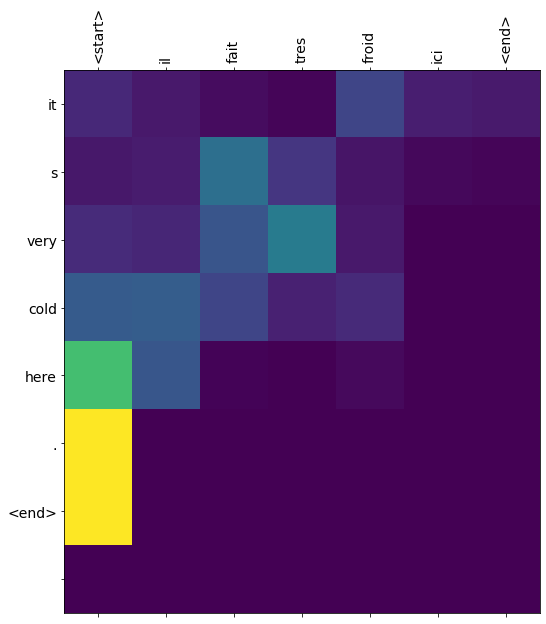

Input: <start> ceci est ma vie . <end>
Predicted translation: this is my life . <end> 


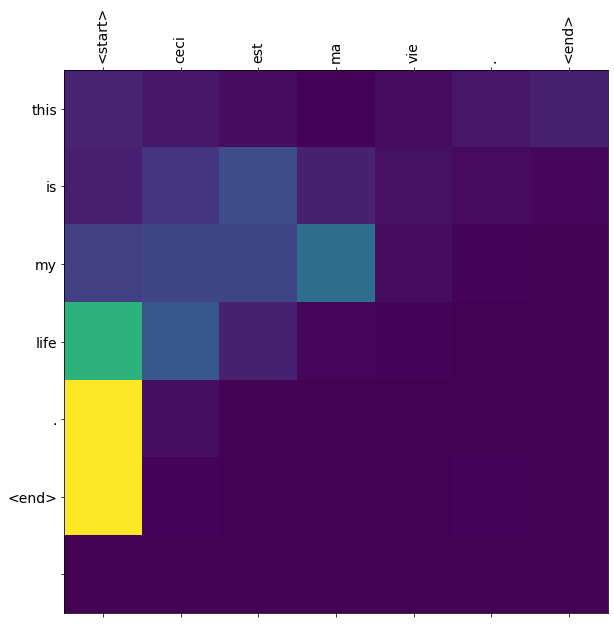

Input: <start> es tu a la maison ? <end>
Predicted translation: are you home ? <end> 


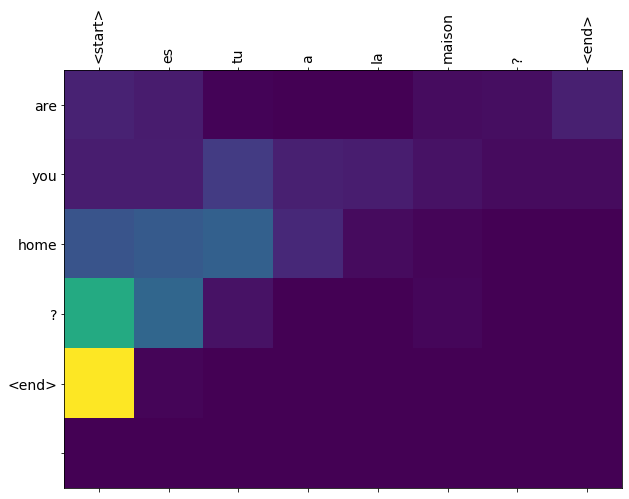

Input: <start> je suis bien content . <end>
Predicted translation: i m well happy . <end> 


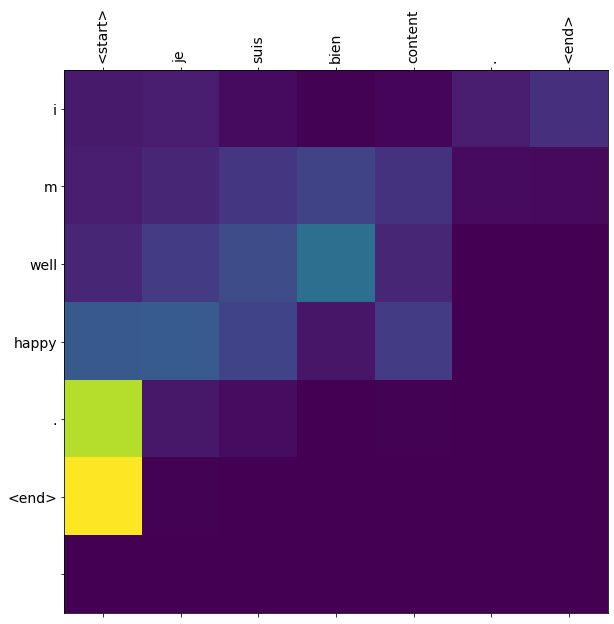

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape


encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# # sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
# # print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


# attention_layer = AdditiveAttention(10)
# attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

# print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
# print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


decoder = Decoder(vocab_tar_size, embedding_dim, 2*units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

optimizer = tf.keras.optimizers.Adam(3e-4)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)


EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    encoder_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (input_batch, target)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(input_batch, target, encoder_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                    total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

print(tf.train.latest_checkpoint(checkpoint_dir))
stat = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


translate(u'il fait tres froid ici', encoder, decoder)

translate(u'ceci est ma vie.', encoder, decoder)

translate(u'es tu a la maison?', encoder, decoder)

translate(u'je suis bien content.', encoder, decoder)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "./training_checkpoints/ckpt-5"* /content/drive/My\ Drive/Colab\ Notebooks/

In [0]:
!ls

drive  sample_data  training_checkpoints
